In [1]:
# Fix randomness and hide warnings
seed = 42

from pathlib import Path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
import keras_cv
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(seed)
print(f"TensorFlow version {tf.__version__}")
tfk.utils.set_random_seed(seed)


# Import other libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rc('font', size=14)
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, recall_score, precision_score, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from PIL import Image
from collections import Counter
import cv2

import keras
from keras import layers

# TF imports related to tf.data preprocessing
from tensorflow import clip_by_value
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import random as tf_random

# Set global policy for training precision
tfk.mixed_precision.set_global_policy('mixed_float16')

cwd = Path(os.getcwd())
input_dir = cwd.parent / 'input'

print('input directory: ', input_dir)
print('current working directory: ', cwd)

TensorFlow version 2.16.1
input directory:  /kaggle/input
current working directory:  /kaggle/working


# Load dataset and inspect

Images shape:  (11951, 96, 96, 3)
labels shape:  (11951, 1)
Images dtype:  uint8
labels dtype:  uint8
max min images:  255 0
max min labels:  7 0


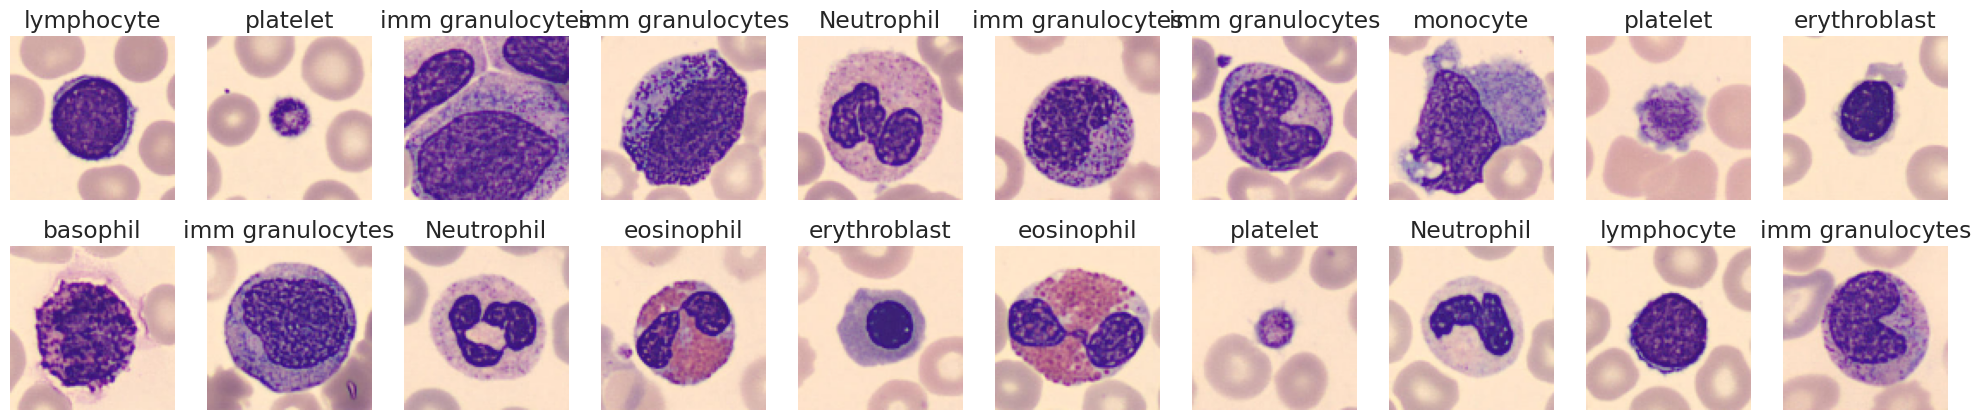

In [2]:
dataset_dir = input_dir / 'ann-h1-round1-dataset'
dataset_name = 'training_set_cleaned.npz'

data = np.load(dataset_dir / dataset_name)
X = data['images']
y = data['labels']
print('Images shape: ', X.shape)
print('labels shape: ', y.shape)
print('Images dtype: ', X.dtype)
print('labels dtype: ', y.dtype)
print('max min images: ', np.max(X), np.min(X))
print('max min labels: ', np.max(y), np.min(y))
labels = {0:'basophil',
          1: 'eosinophil',
          2: 'erythroblast',
          3: 'imm granulocytes',
          4: 'lymphocyte',
          5: 'monocyte',
          6: 'Neutrophil',
          7: 'platelet'}

fig, ax = plt.subplots(2,10, figsize=(25,5))
ax = ax.flatten()


for i in range(len(ax)):
  idx = random.randint(0,X.shape[0]-1)
  ax[i].imshow(X[idx,:,:,:])
  ax[i].axis('off')
  ax[i].set_title(f'{labels[y[idx][0]]}')
plt.show()

## compute class weights

In [3]:
labels_arr = np.array(list(labels.keys()))
y.ravel().shape

(11951,)

In [4]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y), 
                                     y=y.ravel())
print(class_weights)


weights = {}
for i, value in enumerate(class_weights):
    weights[i] = value

weights

[1.7575     0.68557825 1.37684332 0.73844538 1.75957008 1.50592238
 0.64114807 0.90923615]


{0: 1.7575,
 1: 0.6855782469022488,
 2: 1.3768433179723503,
 3: 0.7384453781512605,
 4: 1.7595700824499412,
 5: 1.505922379032258,
 6: 0.6411480686695279,
 7: 0.9092361533779671}

Transform y to categorical

In [5]:
y = tfk.utils.to_categorical(y)
print('labels categoriche: ',y.shape)

labels categoriche:  (11951, 8)


## Perform train test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=seed, stratify=y)

print('X train: ', X_train.shape)
print('y train: ',y_train.shape)

print('X test: ', X_test.shape)
print('y test: ',y_test.shape)

print('y_train type: ', y_train.dtype)

X train:  (10755, 96, 96, 3)
y train:  (10755, 8)
X test:  (1196, 96, 96, 3)
y test:  (1196, 8)
y_train type:  float64


## Convert to tensorflow dataset object

In [7]:
AUTO = tf_data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 96

Occhio che qua faccio un cast a float32

In [8]:
def to_dict(image, label):
    label = tf.cast(label, dtype=tf.float16)
    image = tf.cast(image, dtype=tf.float32)
    return {"images": image, "labels": label}

def load_dataset(split):
    if split == 'train':
        ds = (
            tf_data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(10 * BATCH_SIZE, seed=seed)
            .map(to_dict, num_parallel_calls=AUTO)
            .batch(BATCH_SIZE)
        )
        return ds
    elif split == 'test':
        ds = (
            tf_data.Dataset.from_tensor_slices((X_test, y_test))
            .map(to_dict, num_parallel_calls=AUTO)
            .batch(BATCH_SIZE)
        )
        return ds


train_ds = load_dataset('train')
test_ds = load_dataset('test')


In [9]:
for sample in train_ds.take(1):
    print(sample.keys())  # Dovrebbe stampare: dict_keys(['images', 'labels'])
    print(sample["images"].shape)  # Stampa la shape delle immagini
    print(sample["labels"].shape)  # Stampa la shape delle label

for sample in train_ds.take(1):
    print(f"Min pixel value: {tf.reduce_min(sample['images'])}\nMax pixel value: {tf.reduce_max(sample['images'])}")
print(train_ds.element_spec)
print(test_ds.element_spec)

dict_keys(['images', 'labels'])
(32, 96, 96, 3)
(32, 8)
Min pixel value: 3.0
Max pixel value: 255.0
{'images': TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 8), dtype=tf.float16, name=None)}
{'images': TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 8), dtype=tf.float16, name=None)}


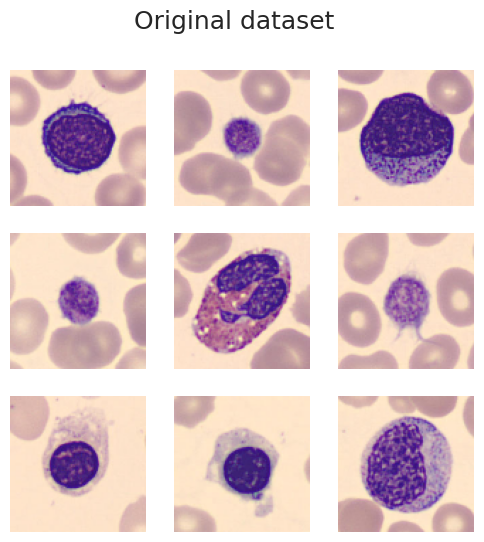

In [10]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()



visualize_dataset(train_ds, 'Original dataset')

# Random augmentation layer

In [11]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=1,
    magnitude=0.5,
    magnitude_stddev=0.3,
    rate=0.6,
)


def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs


In [12]:
layers_rnd_aug = keras_cv.layers.RandAugment.get_standard_policy(value_range=(0, 255),
    magnitude=0.5,
    magnitude_stddev=0.2)

print('layers di augmentation')
print(layers)

layers di augmentation
<module 'keras.api.layers' from '/opt/conda/lib/python3.10/site-packages/keras/api/layers/__init__.py'>


# Channel shift layer

In [13]:
ch_shift = keras_cv.layers.RandomChannelShift(
    value_range=(0,255), factor=0.7, channels=3, seed=seed)


def apply_ch_shift(inputs):
    inputs['images'] = ch_shift(inputs['images'])
    return inputs


# Color degeneration layer

In [14]:
color_deg = keras_cv.layers.RandomColorDegeneration(factor=0.7, seed=seed)

def apply_col_deg(inputs):
    inputs['images'] = color_deg(inputs['images'])
    return inputs


# Catmix e mixup layer

In [15]:
cut_mix = keras_cv.layers.CutMix(seed=seed, alpha=0.4)
mix_up = keras_cv.layers.MixUp(seed=seed, alpha=0.4)

def apply_cut_mix_and_mix_up(samples):
    samples = cut_mix(samples)
    samples = mix_up(samples)
    return samples


In [16]:
layers = layers_rnd_aug


pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=layers, 
    augmentations_per_image=3,
    rate=0.6,
    seed=seed
)

print(layers)

[<AutoContrast name=auto_contrast_1, built=False>, <Equalization name=equalization_1, built=False>, <Solarization name=solarization_1, built=False>, <RandomColorDegeneration name=random_color_degeneration_1, built=False>, <RandomContrast name=random_contrast_1, built=False>, <RandomBrightness name=random_brightness_1, built=False>, <RandomShear name=random_shear_2, built=False>, <RandomShear name=random_shear_3, built=False>, <RandomTranslation name=random_translation_2, built=False>, <RandomTranslation name=random_translation_3, built=False>]


# Grid mask

In [30]:
gm = keras_cv.layers.GridMask(
    ratio_factor=(0, 0.5),
    rotation_factor=0.15,
    fill_mode="constant",
    fill_value=0.0,
    seed=seed
)

def apply_grid_mask(dataset):
    dataset['images'] = gm(dataset['images'])
    return dataset

# Apply augmentation pipeline
HERE with the .map method you can call all augmentation layers that you want and that you have defined above

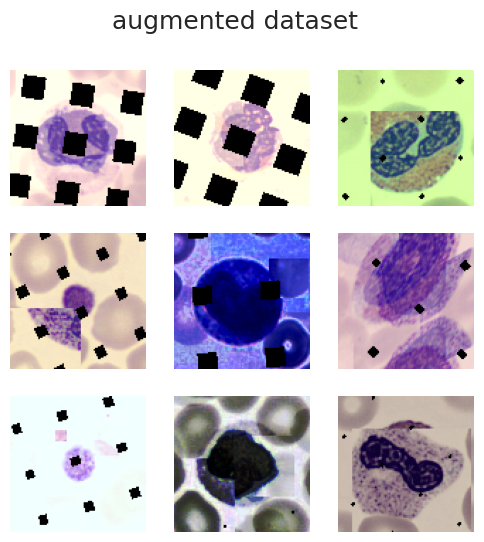

In [32]:


train_ds_prep = (train_ds
                 .map(apply_cut_mix_and_mix_up, num_parallel_calls=AUTO)
                 .map(apply_rand_augment, num_parallel_calls=AUTO)
                 .map(apply_ch_shift, num_parallel_calls=AUTO)
                 .map(apply_grid_mask, num_parallel_calls=AUTO)
                 
                )
visualize_dataset(train_ds_prep, title='augmented dataset')

# Prepare for training

In [108]:
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

# Prepare TRAIN dataset for training
train_dataset_ready = train_ds.map(preprocess_for_model, num_parallel_calls=AUTO)


# Prepare TEST dataset for training
test_dataset_ready = test_ds.map(preprocess_for_model, num_parallel_calls=AUTO)

# Implement PREFETCH
#train_dataset_ready = train_dataset.prefetch(AUTO)
#test_dataset_ready = test_dataset.prefetch(AUTO)

In [109]:
for images, labels in train_dataset_ready.take(1):
    print(f"Min pixel value: {tf.reduce_min(images)}\nMax pixel value: {tf.reduce_max(images)}")
    print(images.shape)
    print(images.dtype)
    print(labels.shape)


Min pixel value: 2.0
Max pixel value: 255.0
(32, 96, 96, 3)
<dtype: 'float32'>
(32, 8)


# Set up the model and train

In [110]:
base_model = tfk.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3),
)

base_model.trainable = False

In [111]:
# for i, layer in enumerate(base_model.layers):
#   print(i, layer.name, type(layer).__name__, layer.trainable)

In [112]:
def build_model(input_shape, 
                output_shape, 
                augmentation=None, 
                learning_rate=1e-3, 
                plot_model=False, 
                name='model', 
                glob_avg_needed=False):
    
    input = tfkl.Input(shape=input_shape, name='Input_layer')
    
    if augmentation:
        x= augmentation(input)  
        x = tfk.applications.efficientnet.preprocess_input(x)
    else:
        x = tfk.applications.efficientnet.preprocess_input(input)

    # connect to the base model
    x = base_model(x)

    if glob_avg_needed:
        # Make a global avarage if not included in the pretrained architecture
        x = tfkl.GlobalAveragePooling2D()(x)
    
    x = tfkl.Dropout(0.2, name='dropout2')(x)

    # 1st dense layer of the classifier
    x = tfkl.Dense(units=1024, activation='relu', name='dense1')(x)
    # x = tfkl.Dropout(0.2, name='drop_dense_1')(x)

    # 2nd dense layer of the classifier
    x = tfkl.Dense(units=512, activation='relu', name='dense2')(x)
    
    # 3rd dense layer of the classifier
    x = tfkl.Dense(units=256, activation='relu', name='dense3')(x)
    # x = tfkl.Dropout(0.2, name='drop_dense_2')(x)

    # 4th dense layer of the classifier
    x = tfkl.Dense(units=64, activation='relu', name='dense4')(x)
    
    # output layer
    output = tfkl.Dense(units=output_shape, activation='softmax', name='output')(x)
    
    # Create a Model connecting input and output
    model = tfk.Model(inputs=input, outputs=output, name=name)
    
    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                  optimizer=tfk.optimizers.Lion(learning_rate),
                  metrics=['accuracy'])
        
    if plot_model:
        model.summary()
        tfk.utils.plot_model(model, show_shapes=True, dpi=70)

    return model

In [113]:
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    #tfkl.RandomContrast(0.3),
    #tfkl.RandomBrightness(0.3, value_range=(0.0, 1.0), seed=seed),
    
], name='Augmentation')

In [114]:
#initial_model = training_model()
#initial_model.save_weights("initial_weights.weights.h5")
lr = 1e-4

model = build_model(input_shape=(96,96,3), 
                    output_shape=8, 
                    augmentation= augmentation, # None, # QUI HO MODIFICATO (era augmentation) 
                    name='efficientB3_catmix_mixup_rnd',
                    glob_avg_needed=True,
                   learning_rate=lr)
model.summary(show_trainable = True)

Model: "efficientB3_catmix_mixup_rnd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input_layer (InputLayer)    │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Augmentation (Sequential)   │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetb4 (Functional) │ (None, 3, 3, 1792)    │ 17,673,823 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_2  │ (None, 1792)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout2 (Dropout)          │ (None, 1792)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense1 (Dense)              │ (None, 1024)          │  1,836,032 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense2 (Dense)              │ (None, 512)           │    524,800 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense3 (Dense)              │ (None, 256)           │    131,328 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense4 (Dense)              │ (None, 64)            │     16,448 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ output (Dense)              │ (None, 8)             │        520 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,182,951 (76.99 MB)

 Trainable params: 2,509,128 (9.57 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [115]:
patience = 20
es = tfk.callbacks.EarlyStopping(monitor='val_accuracy',
                                 mode='max',
                                 patience=patience,
                                 restore_best_weights=True,
                                 start_from_epoch=10)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1
)

rlrop = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=100,
    min_delta=0.0001
)

callbacks = [es,tensorboard_callback,rlrop]

In [116]:
EPOCHS = 100


history = model.fit(train_dataset_ready, 
          validation_data=test_dataset_ready,
          epochs=EPOCHS, 
          callbacks=callbacks,
          class_weight=weights).history

Epoch 1/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.4692 - loss: 1.4478 - val_accuracy: 0.7157 - val_loss: 0.7784 - learning_rate: 1.0000e-04
Epoch 2/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.6900 - loss: 0.8226 - val_accuracy: 0.7492 - val_loss: 0.6829 - learning_rate: 1.0000e-04
Epoch 3/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.7022 - loss: 0.7956 - val_accuracy: 0.7600 - val_loss: 0.6600 - learning_rate: 1.0000e-04
Epoch 4/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.7235 - loss: 0.7482 - val_accuracy: 0.7592 - val_loss: 0.6542 - learning_rate: 1.0000e-04
Epoch 5/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.7282 - loss: 0.7319 - val_accuracy: 0.7358 - val_loss: 0.7078 - learning_rate: 1.0000e-04
Epoch 6/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.7331 - loss: 0.7231 - val_accuracy: 0.7542 - val_loss: 0.6762 - learning_rate: 1.0000e-04
Epoch 7/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 6

In [117]:
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = f'{model.name}_' + str(final_val_accuracy) + '.keras'
model.save(model_filename)

Final validation accuracy: 83.61%


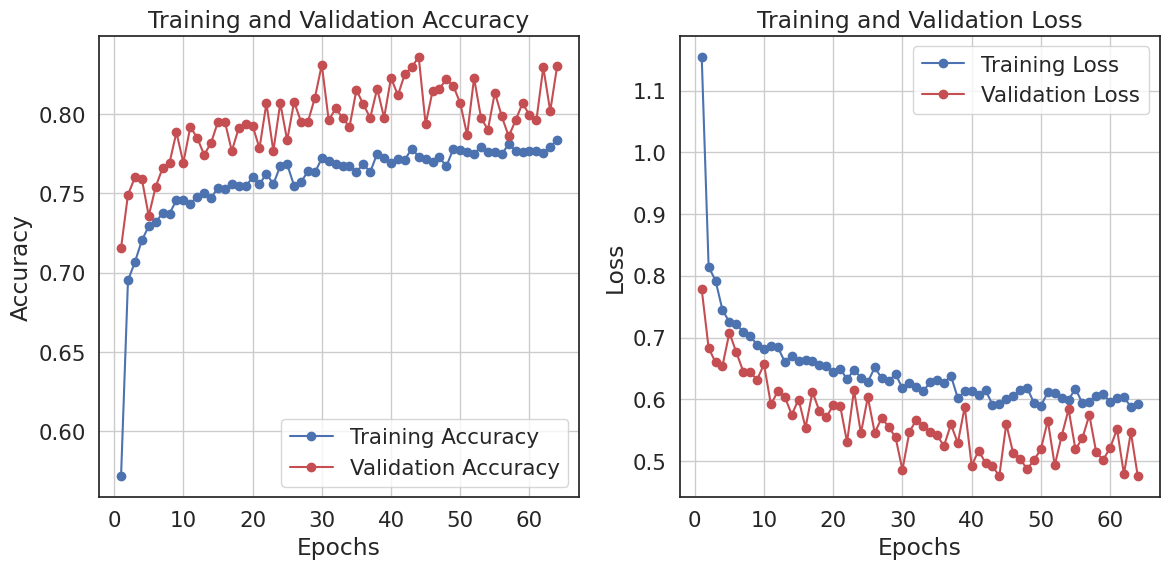

In [118]:
def plot_metrics_from_dict(metrics_dict):
    """
    Funzione per plottare l'andamento di training e validation accuracy, e training e validation loss
    a partire da un dizionario contenente le metriche.

    Parametri:
        metrics_dict: Dizionario con chiavi 'accuracy', 'val_accuracy', 'loss' e 'val_loss'.
    """

    # Estrai le metriche dal dizionario
    acc = metrics_dict.get('accuracy', [])
    val_acc = metrics_dict.get('val_accuracy', [])
    loss = metrics_dict.get('loss', [])
    val_loss = metrics_dict.get('val_loss', [])

    if not acc or not loss:
        print("Errore: Il dizionario fornito non contiene le chiavi 'accuracy' o 'loss'.")
        return

    # Numero di epoche
    epochs = range(1, len(acc) + 1)

    # Plot dell'accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot della loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Mostra i plot
    plt.tight_layout()
    plt.show()


plot_metrics_from_dict(history)

# Fine Tuning 1

In [ ]:
#model = tfk.models.load_model("/kaggle/working/efficientB3_catmix_mixup_rnd_89.81.keras")

Model: "efficientB3_catmix_mixup_rnd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input_layer (InputLayer)    │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Augmentation (Sequential)   │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_flip_2          │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomFlip)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_translation_12  │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomTranslation)         │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_rotation_2      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetb4 (Functional) │ (None, 3, 3, 1792)    │ 17,673,823 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_4          │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ rescaling_4            │ (None, 96, 96, 3)     │          0 │   -   │
│ (Rescaling)                 │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ normalization_2        │ (None, 96, 96, 3)     │          7 │   N   │
│ (Normalization)             │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ rescaling_5            │ (None, 96, 96, 3)     │          0 │   -   │
│ (Rescaling)                 │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_conv_pad          │ (None, 97, 97, 3)     │          0 │   -   │
│ (ZeroPadding2D)             │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_conv (Conv2D)     │ (None, 48, 48, 48)    │      1,296 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_bn                │ (None, 48, 48, 48)    │        192 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_activation        │ (None, 48, 48, 48)    │          0 │   -   │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_dwconv         │ (None, 48, 48, 48)    │        432 │   N   │
│ (DepthwiseConv2D)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_bn             │ (None, 48, 48, 48)    │        192 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_activation     │ (None, 48, 48, 48)    │          0 │   -   │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_se_squeeze     │ (None, 48)            │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │     

 Total params: 22,692,085 (86.56 MB)

 Trainable params: 8,430,432 (32.16 MB)

 Non-trainable params: 11,752,519 (44.83 MB)

 Optimizer params: 2,509,134 (9.57 MB)

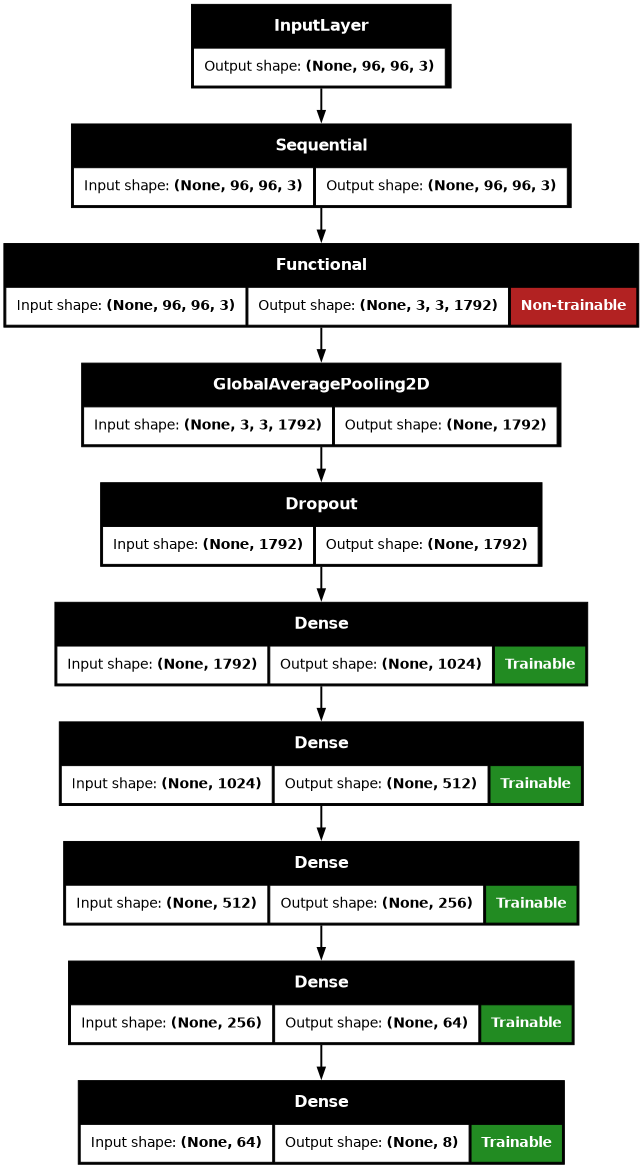

In [120]:
for layer in model.layers[2].layers[-40:]:
    if not isinstance(layer, tfkl.BatchNormalization):
         layer.trainable = True

model.summary(expand_nested=True, show_trainable=True)
tfk.utils.plot_model(model,  show_trainable=True, show_shapes=True, dpi=70)

In [121]:
optimizer = tfk.optimizers.Lion(learning_rate=1e-5)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)
EPOCHS = 50


history = model.fit(train_dataset_ready, 
          validation_data=test_dataset_ready,
          epochs=EPOCHS, 
          callbacks=callbacks).history

Epoch 1/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.7910 - loss: 0.5889 - val_accuracy: 0.8595 - val_loss: 0.4184 - learning_rate: 1.0000e-05
Epoch 2/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.8304 - loss: 0.4726 - val_accuracy: 0.8587 - val_loss: 0.3949 - learning_rate: 1.0000e-05
Epoch 3/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.8441 - loss: 0.4259 - val_accuracy: 0.8729 - val_loss: 0.3632 - learning_rate: 1.0000e-05
Epoch 4/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.8637 - loss: 0.3820 - val_accuracy: 0.8846 - val_loss: 0.3429 - learning_rate: 1.0000e-05
Epoch 5/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.8742 - loss: 0.3604 - val_accuracy: 0.8796 - val_loss: 0.3322 - learning_rate: 1.0000e-05
Epoch 6/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.8769 - loss: 0.3420 - val_accuracy: 0.9022 - val_loss: 0.2886 - learning_rate: 1.0000e-05
Epoch 7/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/ste

Final validation accuracy: 94.98%


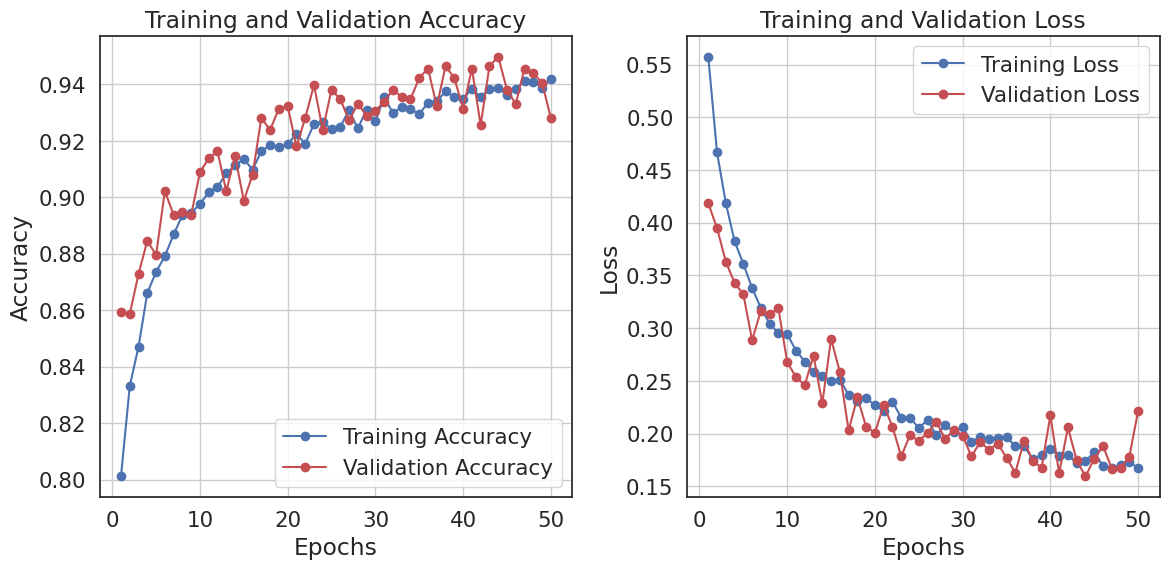

In [122]:
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = f'{model.name}_'+ 'FT1_' + str(final_val_accuracy) + '.keras'
model.save(model_filename)
plot_metrics_from_dict(history)

# Fine Tuning 2

Model: "efficientB3_catmix_mixup_rnd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input_layer (InputLayer)    │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Augmentation (Sequential)   │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_flip_2          │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomFlip)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_translation_12  │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomTranslation)         │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_rotation_2      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetb4 (Functional) │ (None, 3, 3, 1792)    │ 17,673,823 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_4          │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ rescaling_4            │ (None, 96, 96, 3)     │          0 │   -   │
│ (Rescaling)                 │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ normalization_2        │ (None, 96, 96, 3)     │          7 │   N   │
│ (Normalization)             │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ rescaling_5            │ (None, 96, 96, 3)     │          0 │   -   │
│ (Rescaling)                 │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_conv_pad          │ (None, 97, 97, 3)     │          0 │   -   │
│ (ZeroPadding2D)             │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_conv (Conv2D)     │ (None, 48, 48, 48)    │      1,296 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_bn                │ (None, 48, 48, 48)    │        192 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_activation        │ (None, 48, 48, 48)    │          0 │   -   │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_dwconv         │ (None, 48, 48, 48)    │        432 │   N   │
│ (DepthwiseConv2D)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_bn             │ (None, 48, 48, 48)    │        192 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_activation     │ (None, 48, 48, 48)    │          0 │   -   │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_se_squeeze     │ (None, 48)            │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │     

 Total params: 28,613,389 (109.15 MB)

 Trainable params: 10,734,952 (40.95 MB)

 Non-trainable params: 9,447,999 (36.04 MB)

 Optimizer params: 8,430,438 (32.16 MB)

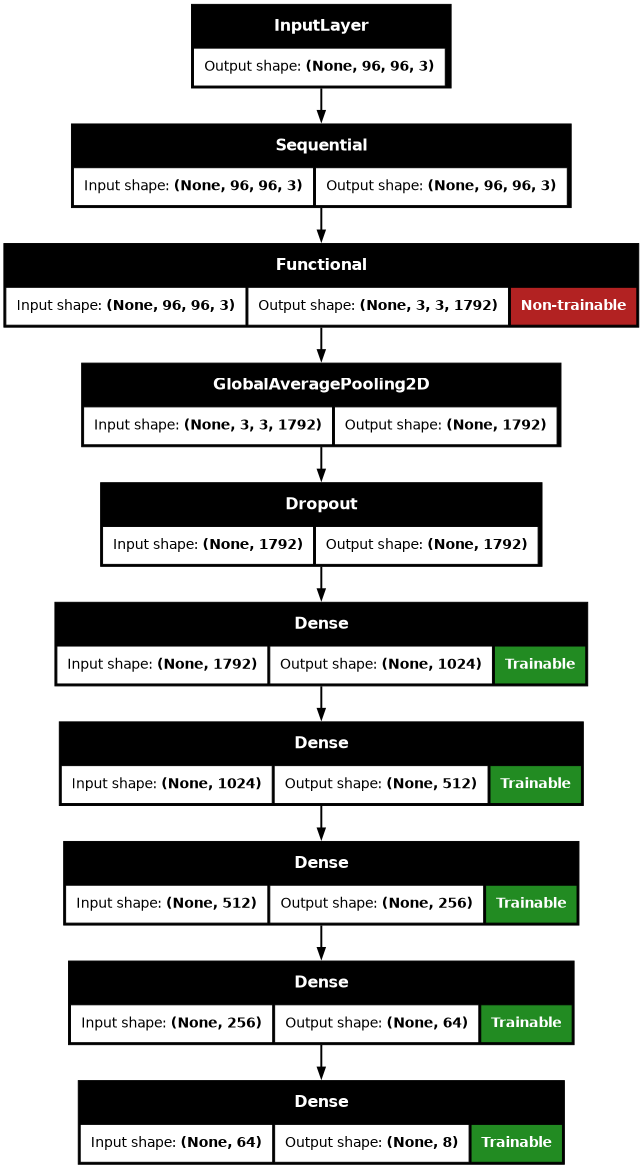

In [124]:
for layer in model.layers[2].layers[-70:]:
    if not isinstance(layer, tfkl.BatchNormalization):
         layer.trainable = True

model.summary(expand_nested=True, show_trainable=True)
tfk.utils.plot_model(model,  show_trainable=True, show_shapes=True, dpi=70)

In [125]:
optimizer = tfk.optimizers.Lion(learning_rate=1e-6)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)
EPOCHS = 10


history = model.fit(train_dataset_ready, 
          validation_data=test_dataset_ready,
          epochs=EPOCHS, 
          callbacks=callbacks).history

Epoch 1/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 56s 88ms/step - accuracy: 0.9421 - loss: 0.1588 - val_accuracy: 0.9431 - val_loss: 0.1627 - learning_rate: 1.0000e-06
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.9456 - loss: 0.1464 - val_accuracy: 0.9373 - val_loss: 0.1790 - learning_rate: 1.0000e-06
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 24s 71ms/step - accuracy: 0.9469 - loss: 0.1437 - val_accuracy: 0.9381 - val_loss: 0.1772 - learning_rate: 1.0000e-06
Epoch 4/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - accuracy: 0.9454 - loss: 0.1491 - val_accuracy: 0.9373 - val_loss: 0.1674 - learning_rate: 1.0000e-06
Epoch 5/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.9487 - loss: 0.1478 - val_accuracy: 0.9381 - val_loss: 0.1752 - learning_rate: 1.0000e-06
Epoch 6/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.9507 - loss: 0.1424 - val_accuracy: 0.9365 - val_loss: 0.1799 - learning_rate: 1.0000e-06
Epoch 7/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/ste

Final validation accuracy: 94.73%


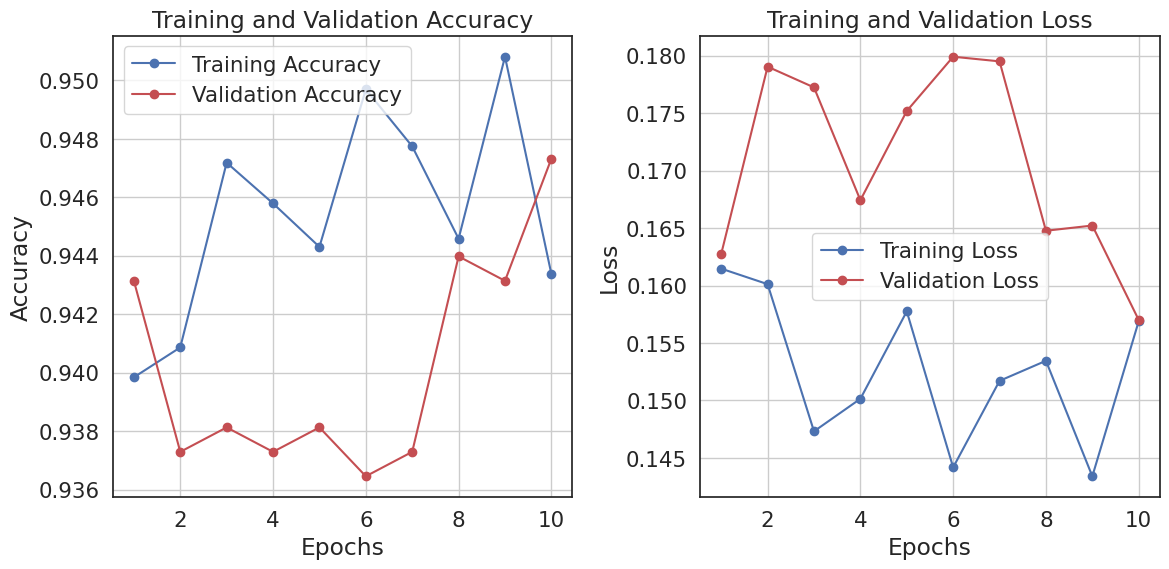

In [126]:
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = f'{model.name}_'+ 'FT2_' + str(final_val_accuracy) + '.keras'
model.save(model_filename)
plot_metrics_from_dict(history)